In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Jash@1763",
                            database = "ecommerce")

cur = db.cursor()



# List all unique cities where customers are located.

In [24]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [25]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total number of orders placed in 2017 are", data[0][0]

('Total number of orders placed in 2017 are', 90202)

# Find the total sales per category.

In [26]:
query = """ select products.product_category category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = [ "Category", "Salees"])
df

,Category,Salees
0,perfumery,4053909.28
1,Furniture Decoration,11441411.13
2,telephony,3895056.41
3,bed table bath,13700429.37
4,automotive,6818354.65
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


# Calculate the percentage of orders that were paid in installments.

In [27]:
query = """ select (sum(case when payment_installments >=3 then 1 else 0 end))/count(*)*100
from payments
"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('37.4690'))

# Count the number of customers from each state. 

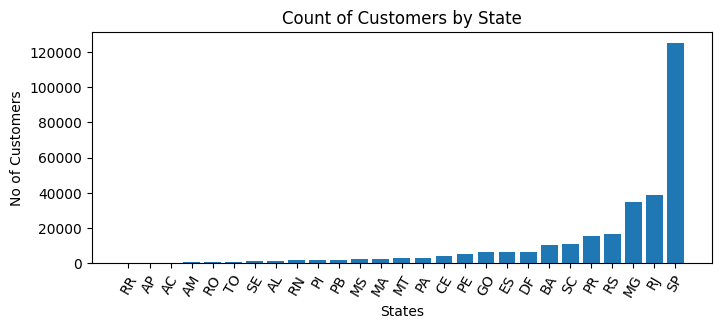

In [28]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
data
dp = pd.DataFrame(data, columns = ["State", "No of Customers"])
dp = dp.sort_values(by = "No of Customers", ascending = True)

plt.figure(figsize = (8,3))
plt.bar(dp["State"],dp["No of Customers"])
plt.xticks(rotation = 60)
plt.xlabel("States")
plt.ylabel("No of Customers")
plt.title("Count of Customers by State")
plt.show()

# Calculate the number of orders per month in 2018.

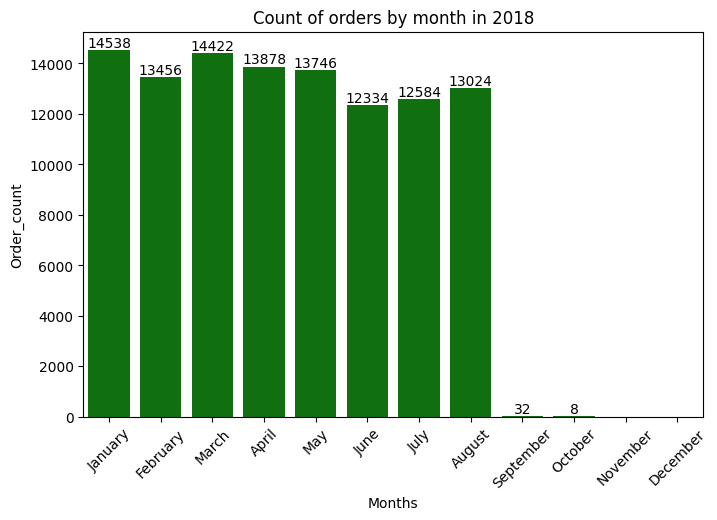

In [29]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months", "Order_count"])
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]


plt.figure(figsize = (8,5))
ax = sns.barplot(x = df["Months"], y = df["Order_count"], data = df, order = o, color = "Green")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45)
plt.title("Count of orders by month in 2018")
plt.show()



# Find the average number of products per order, grouped by customer city.

In [30]:
query = """ with count_per_order as 
(select count(order_items.order_id) as oc, orders.order_id, orders.customer_id
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city cs, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by cs asc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["City","Avd products per order"])
df.head(10)

,City,Avd products per order
0,abadia dos dourados,4.00
1,abadiania,4.00
2,abaete,4.00
3,abaetetuba,5.09
4,abaiara,4.00
5,abaira,4.00
6,abare,4.00
7,abatia,4.00
8,abdon batista,8.00
9,abelardo luz,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [31]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["City","percentage distribution"])
df.head()


,City,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


# Identify the correlation between product price and the number of times a product has been purchased.

In [32]:
query = """ select p.product_category, count(ot.product_id), round(avg(ot.price),2)
from products p join order_items ot
on p.product_id = ot.product_id
group by p.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category","Order_count","Price"])
df

arr1 = df["Order_count"]
arr2 = df["Price"]

a = np.corrcoef([arr1,arr2]) 
print("The correlation between product price and the number of times a product has been purchased is", a[0][1])
#ignore the diagonal elements, compare the value if its equal to zero or not
#correlation exists between 1 and -1
#1 = proportional, -1 = inversely pro.

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

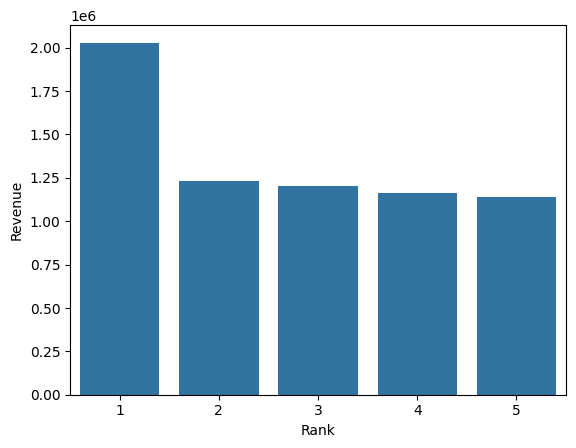

In [33]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select ot.seller_id as seller, sum(p.payment_value) revenue 
from order_items ot join payments p
on ot.order_id = p.order_id
group by seller) as a
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Seller id","Revenue", "Rank"])
df = df.head()
ax = sns.barplot(x = "Rank", y = "Revenue", data = df)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [34]:
query = """ select customer_id, opt, pv, avg(pv) over(partition by customer_id 
order by opt rows between 2 preceding and current row) as mov_avg
from
(select o.customer_id, o.order_purchase_timestamp as opt, p.payment_value as pv
from payments p join orders o
on p.order_id = o.order_id) as a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id", "Order Purchase timestamp", "Price", "Moving Avg"])
df

,Seller_id,Order Purchase timestamp,Price,Moving Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [35]:
query = """select years, months,payment, sum(payment)
over(order by years,months) from
(select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,
round(sum(p.payment_value),2) as payment
from orders o join payments p
on o.order_id = p.order_id
group by years, months order by years, months) as a;

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Month","Sales", "Cummulative sales"])
df

,Year,Month,Sales,Cummulative sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate the year-over-year growth rate of total sales.

In [36]:
query = """ with a as(select year(o.order_purchase_timestamp) as years,
round(sum(p.payment_value),2) as payment
from orders o join payments p
on o.order_id = p.order_id
group by years order by years)

select years, round(((payment - lag(payment, 1) over(order by years))/
lag(payment,1) over(order by years)),2)*100 from a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","YOY % growth"])
df

,Years,YOY % growth
0,2016,NaN
1,2017,12113.0
2,2018,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [37]:
query = """ with a as(select c.customer_id, 
min(o.order_purchase_timestamp) first_order
from customers c join orders o
on c.customer_id = o.customer_id
group by c.customer_id),

b as(select a.customer_id, 
count(distinct o.order_purchase_timestamp) next_order
from a join orders o
on o.customer_id = a.customer_id
and o.order_purchase_timestamp > first_order
and o.order_purchase_timestamp < date_add(first_order,interval 32 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""
# since none of our customers are repeated, the vale is null.
cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

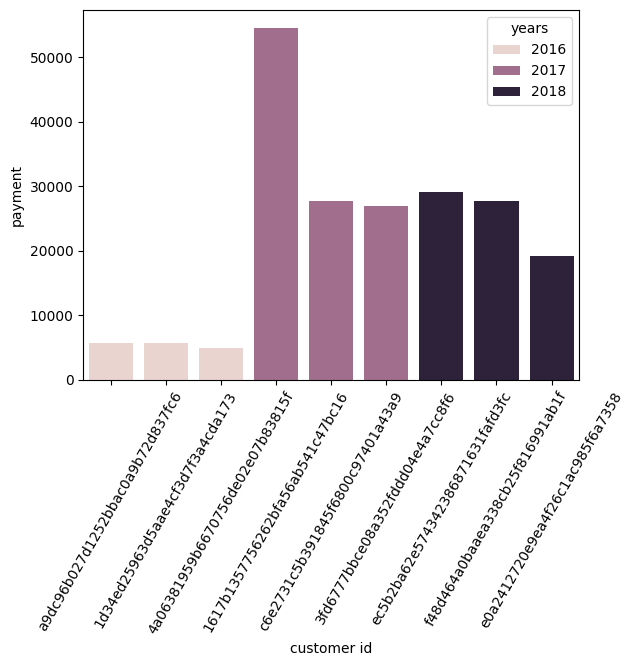

In [38]:
query = """ select years, customer_id, payment, d_rank
from (select year(o.order_purchase_timestamp) years, o.customer_id, 
sum(p.payment_value) payment,
dense_rank() over(partition by year(o.order_purchase_timestamp)
order by sum(p.payment_value) desc) d_rank
from orders o join payments p 
on p.order_id = o.order_id
group by year(o.order_purchase_timestamp), o.customer_id) as a
where d_rank <=3
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","customer id", "payment","rank"])
ax = sns.barplot(x = "customer id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 60)
plt.show()